In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## 1. Data Loading & Preprocessing

In [2]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

mask_train = (train_labels == 2) | (train_labels == 6)
mask_test  = (test_labels  == 2) | (test_labels  == 6)

X_train = train_images[mask_train].reshape(-1, 784).astype('float32') / 255.0
X_test  = test_images[mask_test].reshape(-1, 784).astype('float32')  / 255.0

y_train = np.where(train_labels[mask_train] == 2, -1, 1)
y_test  = np.where(test_labels[mask_test]   == 2, -1, 1)

print(f'Train: {X_train.shape}, Test: {X_test.shape}')

Train: (11876, 784), Test: (1990, 784)


## 2. Gaussian (RBF) Kernel

$$k(\mathbf{x}_i, \mathbf{x}_j) = \exp\!\left(-\frac{\|\mathbf{x}_i - \mathbf{x}_j\|^2}{2\sigma^2}\right)$$

Replaces the Euclidean distance in standard k-NN with a kernel-induced similarity measure, implicitly mapping inputs to a high-dimensional feature space.

In [3]:
def rbf_kernel_matrix(X1, X2, sigma=1.0):
    X1_sq   = np.sum(X1 ** 2, axis=1, keepdims=True)
    X2_sq   = np.sum(X2 ** 2, axis=1, keepdims=True)
    dist_sq = X1_sq + X2_sq.T - 2 * X1 @ X2.T
    return np.exp(-dist_sq / (2 * sigma ** 2))

def kernel_knn_predict(X_train, y_train, X_query, k, sigma=1.0):
    K         = rbf_kernel_matrix(X_query, X_train, sigma)
    k_idx     = np.argpartition(K, -k, axis=1)[:, -k:]
    votes     = np.sum(y_train[k_idx], axis=1)
    preds     = np.where(votes > 0, 1, -1)
    return preds

def zero_one_loss(y_true, y_pred):
    return np.mean(y_true != y_pred)

## 3. Experiments: k ∈ {3, 5}

In [4]:
sigma    = 1.0
k_values = [3, 5]
results  = {}

for k in k_values:
    train_pred = kernel_knn_predict(X_train, y_train, X_train, k, sigma)
    test_pred  = kernel_knn_predict(X_train, y_train, X_test,  k, sigma)

    results[k] = {
        'train_loss': zero_one_loss(y_train, train_pred),
        'test_loss':  zero_one_loss(y_test,  test_pred),
    }
    print(f'k={k}: Train Loss={results[k]["train_loss"]:.4f} | Test Loss={results[k]["test_loss"]:.4f}')

k=3: Train Loss=0.0003 | Test Loss=0.0010


k=5: Train Loss=0.0008 | Test Loss=0.0015


## 4. Visualization

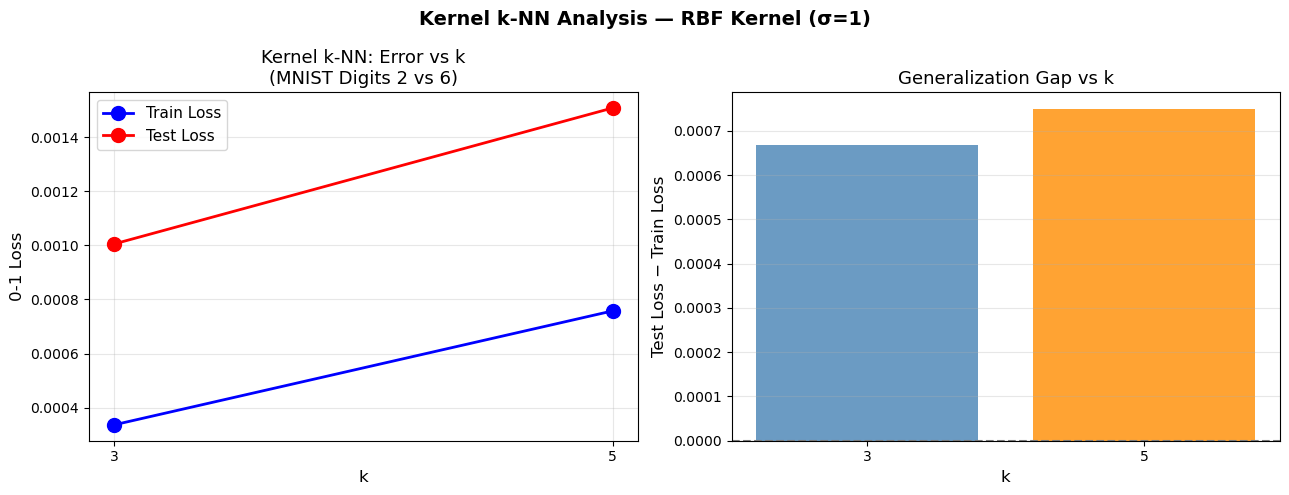

In [5]:
k_arr      = np.array(k_values)
train_errs = np.array([results[k]['train_loss'] for k in k_values])
test_errs  = np.array([results[k]['test_loss']  for k in k_values])

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].plot(k_arr, train_errs, 'bo-', linewidth=2, markersize=10, label='Train Loss')
axes[0].plot(k_arr, test_errs,  'ro-', linewidth=2, markersize=10, label='Test Loss')
axes[0].set_xlabel('k', fontsize=12)
axes[0].set_ylabel('0-1 Loss', fontsize=12)
axes[0].set_title('Kernel k-NN: Error vs k\n(MNIST Digits 2 vs 6)', fontsize=13)
axes[0].legend(fontsize=11); axes[0].grid(True, alpha=0.3); axes[0].set_xticks(k_arr)

gen_gap = test_errs - train_errs
axes[1].bar([str(k) for k in k_values], gen_gap, color=['steelblue', 'darkorange'], alpha=0.8)
axes[1].axhline(y=0, color='gray', linestyle='--')
axes[1].set_xlabel('k', fontsize=12)
axes[1].set_ylabel('Test Loss − Train Loss', fontsize=12)
axes[1].set_title('Generalization Gap vs k', fontsize=13)
axes[1].grid(True, alpha=0.3, axis='y')

plt.suptitle('Kernel k-NN Analysis — RBF Kernel (σ=1)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('results/kernel_knn_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Results Summary

In [6]:
best_k = min(results, key=lambda k: results[k]['test_loss'])

print('{:>4}  {:>12}  {:>10}  {:>10}'.format('k','Train Loss','Test Loss','Gen. Gap'))
print('-' * 42)
for k in k_values:
    r   = results[k]
    gap = r['test_loss'] - r['train_loss']
    tag = ' <- best' if k == best_k else ''
    print('{:>4}  {:>12.4f}  {:>10.4f}  {:>10.4f}{}'.format(k, r['train_loss'], r['test_loss'], gap, tag))

print(f'\nKernel: RBF  σ={sigma}  |  Best k={best_k}')

   k    Train Loss   Test Loss    Gen. Gap
------------------------------------------
   3        0.0003      0.0010      0.0007 <- best
   5        0.0008      0.0015      0.0007

Kernel: RBF  σ=1.0  |  Best k=3
